In [1]:
#Load modules
import zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yaml
from pathlib import Path
import allel

from dask.distributed import Client
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False}) # Silence large chunk warnings
import dask.array as da
from dask import delayed, compute
from dask_gateway import Gateway
import functools
import numcodecs
from fsspec.implementations.zip import ZipFileSystem
from collections.abc import Mapping
import gcsfs
import numba
import psutil
from humanize import naturalsize

import pickle
import platform

import traceback
import logging

from pyprojroot import here
from bokeh.plotting import *
import plotly.express as px
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator

import xarray as xr
import malariagen_data
from scipy.cluster.hierarchy import linkage

import matplotlib.colors as colors
import matplotlib as mpl
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

### Connect to gcs

In [ ]:
gcs = gcsfs.GCSFileSystem()

In [ ]:
gcs.ls('vo_afun_release_master_us_central1')[:3]

### Set up data access

In [5]:
production_root = Path('vo_afun_release_master_us_central1')
vo_afun_staging = Path(production_root, 'v1.0')
sampleset_staging_dir = Path(vo_afun_staging, 'snp_genotypes', 'all')

#Decision tree or static filters
genomic_positions_site_filter_dt_data_cloud_zarr_dir = 'vo_afun_release_master_us_central1/v1.0/site_filters/dt_20200416/funestus'
genomic_positions_site_filter_sc_data_cloud_zarr_dir = 'vo_afun_release_master_us_central1/v1.0/site_filters/sc_20220908/funestus'

repo_clone_path = here()
release_config_path = repo_clone_path / 'analysis' / 'config.yml'

with open(release_config_path) as fh:
    config = yaml.load(fh, Loader=yaml.BaseLoader)
    
samplesets = config["sample_sets"]

In [ ]:
metadata = pd.read_csv("../../metadata/supp1_tab2.csv")
snp_metadata = pd.read_csv('samples_A296S-T345S.csv')

In [6]:
#Access the data from the cloud.
af1 = malariagen_data.Af1()
af1

<MalariaGEN Af1 API client>
Storage URL             : gs://vo_afun_release/
Data releases available : 1.0
Results cache           : None
Cohorts analysis        : 20240515
Site filters analysis   : dt_20200416
Software version        : malariagen_data 9.0.1
Client location         : unknown
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v9.0.1/Af1.html

### Settings

In [7]:
release = '1.0'
release_version = 'v1.0'
analysis = 'funestus'
chromosomes = ['2RL', '3RL', 'X']

In [8]:
geo_cohort_map = {
    'Gabon_Haut-Ogooue': 'GA',
    'CAR_Ombella-MPoko': 'CF',
    'Cameroon_Adamawa': 'CM',
    'Ghana_Ashanti-Region': 'GH-A',
    'Malawi_Southern-Region': 'MW',
    'Mozambique_Maputo': 'MZ-M',
    'Uganda_Eastern-Region': 'UG',
    'Benin_Atlantique-Dept': 'BJ',
    'DRC_Kinshasa': 'CD-K',
    'Nigeria_Ogun-State': 'NG',
    'Zambia_Eastern-Prov': 'ZM',
    'Kenya_Nyanza-Prov': 'KE-N',
    'Kenya_Western-Prov': 'KE-W',
    'Tanzania_Morogoro-Region': 'TZ',
    'DRC_Haut-Uele': 'CD-H',
    'Mozambique_Cabo-Delgado': 'MZ-C'
}

# Inject extra metadata

In [10]:
karyotype_color = {
    '3Ra/a': '#F59D2E',  # yellow
    '3R+/+': '#60689E',  # blue
    '3R+/a': '#71a354'   # green
}

In [11]:
A296S_color = {
    1: '#c00000',  # red
    .5: '#ff9696',  # pink
    0: '#ffffff'   # white
}

In [12]:
T345S_color = {
    1: '#0066ff',  # blue
    .5: '#9BC2FF',  # light blue
    0: '#ffffff'   # white
}

In [13]:
# extract the sample sets
sample_sets = af1.sample_sets(release=f"{release}")['sample_set'].tolist()
sample_sets

['1229-VO-GH-DADZIE-VMF00095',
 '1230-VO-GA-CF-AYALA-VMF00045',
 '1231-VO-MULTI-WONDJI-VMF00043',
 '1232-VO-KE-OCHOMO-VMF00044',
 '1235-VO-MZ-PAAIJMANS-VMF00094',
 '1236-VO-TZ-OKUMU-VMF00090',
 '1240-VO-CD-KOEKEMOER-VMF00099',
 '1240-VO-MZ-KOEKEMOER-VMF00101']

In [17]:
metadata = metadata.merge(snp_metadata, on='sample_id')
metadata['karyotype_3Ra_colour'] = metadata['karyotype_3Ra'].map(karyotype_color)
metadata['A296S_colour'] = metadata['A296S'].map(A296S_color)
metadata['T345S_colour'] = metadata['T345S'].map(T345S_color)
metadata

,sample_id,geographic_cohort,geographic_cohort_colour,geographic_cohort_shape,PCA_cohort,PCA_cohort_colour,mitochondrial_id,karyotype_3La,karyotype_3Ra,karyotype_3Rb,karyotype_2Ra,karyotype_2Rh,median_coverage,A296S,T345S,karyotype_3Ra_colour,A296S_colour,T345S_colour
0,VBS17729,Gabon_Haut-Ogooue,#ff7f0e,circle,S_central,#ff7f0e,funestus-lineageI-clusterA,3La/a,3Ra/a,3Rb/b,2R+/a,2R+/h,42,0.0,0.0,#F59D2E,#ffffff,#ffffff
1,VBS17730,Gabon_Haut-Ogooue,#ff7f0e,circle,S_central,#ff7f0e,funestus-lineageI-clusterA,3La/a,3Ra/a,3Rb/b,2R+/+,2Rh/h,36,0.0,0.0,#F59D2E,#ffffff,#ffffff
2,VBS17731,Gabon_Haut-Ogooue,#ff7f0e,circle,S_central,#ff7f0e,funestus-lineageI-clusterA,3La/a,3R+/a,3R+/b,2R+/a,2R+/h,36,0.0,0.0,#71a354,#ffffff,#ffffff
3,VBS17732,Gabon_Haut-Ogooue,#ff7f0e,circle,S_central,#ff7f0e,funestus-lineageI-clusterA,3La/a,3Ra/a,3Rb/b,2R+/+,2R+/h,42,0.0,0.0,#F59D2E,#ffffff,#ffffff
4,VBS17733,Gabon_Haut-Ogooue,#ff7f0e,circle,S_central,#ff7f0e,funestus-lineageI-clusterA,3La/a,3R+/+,3Rb/b,2R+/a,2R+/h,33,0.0,0.0,#60689E,#ffffff,#ffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,VBS24534,Mozambique_Cabo-Delgado,#17becf,triangle-up,S_east,#1f77b4,funestus-lineageI-clusterA,3L+/a,3R+/a,3R+/+,2R+/+,2R+/+,45,0.0,0.0,#71a354,#ffffff,#ffffff
616,VBS24535,Mozambique_Cabo-Delgado,#17becf,triangle-up,S_east,#1f77b4,funestus-lineageI-clusterA,3L+/a,3R+/a,3R+/+,2R+/+,2R+/+,50,0.0,0.0,#71a354,#ffffff,#ffffff
617,VBS24536,Mozambique_Cabo-Delgado,#17becf,triangle-up,S_east,#1f77b4,funestus-lineageI-clusterA,3La/a,3R+/+,3R+/b,2R+/+,2R+/+,43,0.0,0.0,#60689E,#ffffff,#ffffff
618,VBS24537,Mozambique_Cabo-Delgado,#17becf,triangle-up,S_east,#1f77b4,funestus-lineageI-clusterA,3L+/a,3R+/a,3R+/b,2R+/+,2R+/+,45,0.0,0.0,#71a354,#ffffff,#ffffff


In [ ]:
# load the geographic cohorts
geographic_cohorts = list(metadata.geographic_cohort.dropna().unique())

In [22]:
gc_dict = {}
for gc in geographic_cohorts:
    gc_dict[gc] = "sample_id in ['" + "', '".join([s for s in metadata.query("geographic_cohort == @gc").sample_id]) + "']"

In [ ]:
sample_query = metadata.loc[
    metadata.geographic_cohort.isin(geographic_cohorts),
    'sample_id'
].to_list()


In [24]:
cohort_size = None
min_cohort_size = 10
max_cohort_size = 50
random_seed = 42
cohort_set='geographic_cohort'
cohort_query=None
linkage_method = "single"
filter_maf = True
maf_filter = 0.05
site_mask='funestus'

### Connect to Dask Cluster

In [25]:
gateway = Gateway()

In [26]:
#check if any cluster is currently running
gateway.list_clusters()

[]

In [ ]:
#gateway = Gateway()
conda_prefix = os.environ["CONDA_PREFIX"]
current_environment = 'global/'+conda_prefix.split('/')[5]
cluster = gateway.new_cluster(
    profile='standard', 
    conda_environment = current_environment,
)
cluster

In [ ]:
cluster.scale(20)
client = cluster.get_client()

### Functions

In [35]:
def prep_dendrogram_data(transcripts,
                         cohorts=cohort_query,
                         samples=sample_query,
                         site_mask=site_mask,
                         maf_filter=maf_filter, meta_path=None):

    #load the allele frequency data
    tbl_selecteds = []
    # transcripts = ['LOC125764717_t1', 'LOC125764726_t1', 'LOC125764713_t1']
    for trans in transcripts:
        tbl_selected= af1.snp_allele_frequencies(trans,
                           cohorts=cohorts,
                           site_mask=site_mask).query('max_af > @maf_filter')

        tbl_selecteds.append(tbl_selected)
    tbl_selected = pd.concat(tbl_selecteds)

    #subset to non_synonymous_coding and massage the dataframe
    tbl_selected_redux = tbl_selected.loc[tbl_selected['effect']=='NON_SYNONYMOUS_CODING'].reset_index()

    def concat_unique_values(series):
        return ','.join(series.unique())

    def create_label(row):
        return f"{row['position']}:{row['ref_allele']}>{row['alt_allele']} {row['aa_change']}"

    aggregations = {
        'alt_allele': concat_unique_values,
        'aa_change': 'first',  # Keep the first value, assuming it's the same for each group
        'effect': 'first',  # Keep the first value, assuming it's the same for each group
        'ref_allele': 'first'
    }

    tbl_selected_redux = tbl_selected_redux.groupby(['contig', 'position']).agg(aggregations).reset_index()

    tbl_selected_redux = tbl_selected_redux[['contig', 'position', 'ref_allele', 'alt_allele', 'aa_change', 'effect']]

    tbl_selected_redux['label'] = tbl_selected_redux.apply(create_label, axis=1)

    tbl_selected_redux.rename(columns={'contig': 'CHROM', 'position': 'POS',
                                       'ref_allele':'REF', 'alt_allele':'ALT',
                                      # 'aa_change': f'{transcript}'
                                      },
                                      inplace=True)

    #load the haplotypes for the chrom and positions
    chrom = str(tbl_selected_redux['CHROM'].unique()[0])
    start = int(tbl_selected_redux['POS'].min())
    stop = int(tbl_selected_redux['POS'].max())

    haps = af1.haplotypes(transcripts, sample_query=samples)

    df_samples = metadata

    pos = haps['variant_position'].compute().data

    intersect = np.intersect1d(pos, tbl_selected_redux['POS'])

    inter_loc = [np.where(haps.variant_position.compute() == i)[0][0] for i in intersect]

    tbl_selected_redux = tbl_selected_redux.query("POS in @intersect")

    #extract the missense mutations
    lbl_missense = list(tbl_selected_redux[f'label'])

    return haps, lbl_missense, df_samples, tbl_selected_redux, inter_loc

In [36]:
def _hamming_to_snps(h):
    """
    Cluster haplotype array and return the number of SNP differences
    """

    dist = pdist(h, metric="hamming")
    dist *= h.shape[1]

    return dist

In [37]:
def generate_dist(ds_haps, linkage_method='average'):


    gt = allel.GenotypeDaskArray(ds_haps["call_genotype"].data)
    with af1._dask_progress(desc="Load haplotypes"):
        ht = gt.to_haplotypes().compute()

    #hamming to snps
    d = _hamming_to_snps(ht.T)

    z = linkage(d, 'single')

    max_dist = _get_max_hamming_distance(
        ht.T, metric="hamming", linkage_method=linkage_method
    )

    return z, max_dist, ht

In [38]:
def _get_max_hamming_distance(h, metric="hamming", linkage_method="single"):

    """
    Find the maximum hamming distance between haplotypes
    """

    Z = linkage(h, metric=metric, method=linkage_method)

    # Get the distances column
    dists = Z[:, 2]

    # Convert to the number of SNP differences
    dists *= h.shape[1]

    # Return the maximum
    return dists.max()

In [39]:
def dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sch.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        # plt.title(f"genomic region: {chrom}: {start}-{stop}")
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, c=c)
                # plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                #              textcoords='offset points',
                #              va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [40]:
def plot_haplotypes(ax, h, variant_labels=None, colors=None, vmin=0, vmax=2):
    if colors is None:
        # Default colormap if not provided
        colormap = mpl.colors.ListedColormap(['white', '#5c5c5c'], name='mymap')

    ax.pcolormesh(np.asarray(h[::-1]), cmap=colormap, vmin=vmin, vmax=vmax)

    if variant_labels:
        ax.set_yticks(np.arange(h.shape[0]) + 0.5)
        ax.set_yticklabels(variant_labels[::-1], family='monospace')
        ax.hlines(np.arange(h.shape[0] + 1), 0, h.shape[1], color='k', lw=0.5)

    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])

In [80]:
def plot_dendrogram(transcripts,
                    cohorts=cohort_query,
                    samples=sample_query,
                    site_mask=site_mask,
                    maf_filter=maf_filter,
                    cut=0.0004,
                    yscale='log',
                    linkage_method='average',
                    n_clusters=14,
                    min_cluster_size=10):

    """This function plots a dendrogram using scipy and provides some utilities for annotating clusters."""

    #load the haps_data
    haps_missense, lbl_missense, df_haplotypes, \
            tbl_selected_redux, inter_loc = prep_dendrogram_data(
        transcripts, 
        cohorts=cohorts,
        samples=samples,
        maf_filter=maf_filter)


    #load the dist
    z, max_dist, ht = generate_dist(haps_missense)

    nsamples = tbl_selected_redux.shape[0]

    sample_features = [cohort_set, 'karyotype_3Ra', 'A296S', 'T345S']

    fig, axs = plt.subplots(
        figsize=(15, 9.5), nrows=6, ncols=1,
        # TODO
        gridspec_kw={'height_ratios':[6.5, .3, .3, .3, .3, nsamples * .3], 'hspace':0}
    )
    # gs = mpl.gridspec.GridSpec(

    # )

    # dendrogram
    ax = axs[0]
    sns.despine(ax=ax, offset=3, bottom=True, top=False)

    r = dendrogram(z,
                   no_labels=True,
                   count_sort=True,
                   color_threshold=0,
                   above_threshold_color='k',
                   ax=ax, distance_sort=True,
                   orientation="bottom",
                   annotate_above=False

                )

    df_haps = pd.DataFrame(np.repeat(df_haplotypes.values, 2, axis=0), columns = df_haplotypes.columns)
    df_haplotypes_sorted = df_haps.loc[r['leaves']].copy()
    
    haps_redux = haps_missense.sel(variants=inter_loc)

    #set the y limit, this overides ylim
    ax.set_ylim(-2, max_dist+1)
    # ax.set_ylim(*ylim)
    # ax.set_yscale(yscale)

    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(df_haplotypes_sorted), 200)) + [len(df_haplotypes_sorted)])
    xticks = xticklabels / len(df_haplotypes_sorted)
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, size=12)
    ax.set_xlabel('Haplotypes', size=12)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Distance (no. SNPs)', rotation=90, ha='center', size=12)

    title_lines = []
    title_lines.append(f"genomic region: {chrom}: {start}-{stop} ({ht.shape[0]} SNPs)")

    # title_lines.append(f"genomic region: {chrom}: {start}-{stop}")

    title = "<br>".join(title_lines)
    # title = "\n".join(title_lines)

    ax.set_title(title)

    color = '#D3D3D3'

    if cut:
        cut_height = cut * ht.shape[0]
        ax.axhline(cut_height, linestyle='--', color='k')
        # find clusters
        f = sch.fcluster(z, cut_height, criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n_clusters]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        # keep clusters above minimum size
        clusters = [cl for cl in clusters if len(cl) >= min_cluster_size]
        clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster])
                           for cluster in clusters]
        # ixs = np.argsort([min(cl) for cl in clusters_leaves])
        ixs = np.argsort([min(cl) if cl else np.inf for cl in clusters_leaves])
        clusters = [clusters[i] for i in ixs]
        clusters_leaves = [clusters_leaves[i] for i in ixs]
        for i, cluster_leaves in enumerate(clusters_leaves):
            if not cluster_leaves:
                continue  # Skip empty lists

            x1, x2 = min(cluster_leaves), max(cluster_leaves)

            #skipped to remove shading
            ax.fill_between([x1*10, x2*10], 0, cut_height, color=color, alpha=.4, zorder=20)

    # sample-level colour bars
    for i, label in enumerate(sample_features):
        ax = axs[i + 1]
        sns.despine(ax=ax, left=True, bottom=True)
        ax.broken_barh(
            [(j, 1) for j in range(len(df_haplotypes_sorted))],
            yrange=(0, 1),
            color=df_haplotypes_sorted[f'{label}_colour'].to_list()
        )
        ax.set_xlim(0, len(df_haplotypes_sorted))
        ax.set_yticks([])
        ax.set_ylabel(label, rotation=0, ha='right', va='center', size=12)
        ax.set_xticks([])

        if cut:
            for k, cluster_leaves in enumerate(clusters_leaves):
                if not cluster_leaves:
                    continue  # Skip empty lists
                # color = cluster_palette[k % len(cluster_palette)]
                x1, x2 = min(cluster_leaves), max(cluster_leaves)
                ax.axvline(x1, color='k', linestyle='--', zorder=20)
                ax.axvline(x2, color='k', linestyle='--', zorder=20)

        # legend
        #label_colours = df_haplotypes_sorted.groupby([label,f'{label}_colour']).size().reset_index()
        #handles = [
        #    mpl.patches.Patch(color=row[f'{label}_colour'], label=row[label]) for _, row in label_colours.iterrows()
        #]
        if i == 0:
            y = 1
        else:
            y = 0.88 - i * 0.07
        #legend = axs[0].legend(
        #    handles=handles, loc='upper right', bbox_to_anchor=(1, y), ncol=3,
        #    title=label, title_fontsize=13, prop={'size': 12}
        #)
        #axs[0].add_artist(legend)

    ax = axs[-1]
    haps_redux_d = haps_redux.call_genotype.data
    haps_redux_d = haps_redux_d.reshape(haps_redux_d.shape[0], -1)
    haps_redux_l = haps_redux_d[:,r['leaves']]
    plot_haplotypes(ax, haps_redux_l, lbl_missense)
    ax.set_xlim(0, 2*len(df_haplotypes))
    ax.set_xticks([])
    ax.set_xlabel('Haplotypes')
    if cut:
        for i, cluster_leaves in enumerate(clusters_leaves):
            if not cluster_leaves:
                continue  # Skip empty lists
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)
            ax.axvspan(x1, x2, color=color, zorder=20, alpha=.4)

    plt.tight_layout()

    # #save the figure
    fig.savefig(f'fig/haplotype_clustering_and_mutation_gaba_{cohort_set}.png', dpi=600)
    fig.savefig(f'fig/haplotype_clustering_and_mutation_gaba_{cohort_set}.svg', dpi=300)

    fig.show()
    if cut:
        return clusters, tbl_selected_redux, haps_missense, df_haplotypes_sorted, haps_redux

In [54]:
def save_cluster_membership(fn, h, clusters, clust_labels):

    cluster_membership = np.empty(h.shape[0], dtype='S2')
    cluster_membership[:] = b''
    for cluster, lbl in zip(clusters, clust_labels):
        hidx = sorted(cluster)
        cluster_membership[hidx] = lbl.encode('ascii')[:2]

    np.save(fn, cluster_membership)

In [55]:
def compute_allele_af(tbl_selected_redux, ax=None):
    # global allele_af
    recs = list(tbl_selected_redux.iterrows())
    n = len(recs)
    allele_af = np.zeros(n, dtype='f8')
    for i, (_, rec) in enumerate(recs):
        i_pos = rec['POS']
        #print("position =", i_pos)
        i_allele = 1
        #print(i_allele, 'alleles')
        i_vidx = pos_selected.locate_key(i_pos)
        #print('on key',i_vidx)
        log('row', i, i_vidx, i_pos, i_allele)
        x = ac[i_vidx, i_allele] * 100 / haps_selected.shape[1]
        allele_af[i] = x
        
    return allele_af

In [56]:
def lewontin_d_prime(h, i, j, a=1, b=1):
    """Compute LD between a pair of alleles.
    
    Parameters
    ----------
    h : array
        Haplotype array.
    i : int
        First variant index.
    j : int
        Second variant index.
    a : int
        First variant allele.
    b : int
        Second variant allele.
    
    Returns
    -------
    ld : float
    
    """
    
    # setup
    n_a = n_b = 0  # allele counts
    n_ab = 0  # haplotype counts
    n = 0  # allele number (i.e., number of calls)
    
    # iterate over haplotypes, counting alleles and haplotypes
    for k in range(h.n_haplotypes):
        
        # access alleles
        allele_ik = h[i, k]
        allele_jk = h[j, k]
        
        # only count if allele non-missing at both sites
        if allele_ik < 0 or allele_jk < 0:
            continue
            
        # accumulate
        if allele_ik == a:
            n_a += 1
        if allele_jk == b:
            n_b += 1
        if allele_ik == a and allele_jk == b:
            n_ab += 1
        n += 1
        
    # bail out if no data or either allele is absent or fixed
    if n == 0 or n_a == 0 or n_b == 0 or n == n_a or n == n_b:
        return None
    
    # compute coefficient of linkage disequilibrium * n**2
    D_ab = (n * n_ab) - (n_a * n_b)
    
    # compute normalisation coefficient * n**2
    if D_ab >= 0:
        D_max = min(n_a * (n - n_b), (n - n_a) * n_b)
    else:
        D_max = min(n_a * n_b, (n - n_a) * (n - n_b))

    # compute D prime
    D_prime = D_ab / D_max
    
        
    return D_prime

In [57]:
def compute_ld(tbl_selected_redux, haps_selected):
    # global ld
    recs = list(tbl_selected_redux.iterrows())  # Iterate through rows directly
    n = len(tbl_selected_redux)
    ld = np.zeros((n, n), dtype='f8')  # Initialize a 2D array for LD values
    
    for i, (i_idx, i_row) in enumerate(recs):
        i_pos = i_row['POS']
        i_allele = 1
        i_vidx = pos_selected.locate_key(i_pos)
        # log('row', i, i_vidx, i_pos, i_allele)
        
        for j, (j_idx, j_row) in enumerate(recs[i+1:], start=i+1):
            j_pos = j_row['POS']
            j_allele = 1
            j_vidx = pos_selected.locate_key(j_pos)
            # log('col', j, j_vidx, j_pos, j_allele)
            
            v = lewontin_d_prime(haps_selected, i_vidx, j_vidx, i_allele, j_allele)
            # log('D_prime', v)
            
            ld[i, j] = v
            ld[j, i] = v
            
    return ld

In [58]:
def plot_allele_af(allele_af, ax=None, y_min=0, y_max=100, step=10, **kwargs):
    n = len(allele_af)
    #gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1.3, 6], width_ratios=[7, .5])
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 2))
    left = np.arange(n) + 0.2
    ax.bar(left, allele_af, align='edge', width=0.6, **kwargs)
    ax.set_ylabel('Allele frequency (%)', size=8.5)
    ax.set_xlim(0, n)
    ax.set_xticks([])
    ax.set_yticks(range(y_min, y_max, step))
    ax.set_xticklabels([])
    
    ax.tick_params(axis='y', labelsize=8)

In [59]:
def fig_pw_ld(allele_af, tbl_selected_redux, fname='ld_af_plot', y_min=0, y_max=500, step=10,):

    nsamples = tbl_selected_redux.shape[0]

    fig = plt.figure(figsize=(nsamples * .45, nsamples * .3 + 1), dpi=120)

    gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1.3, 6], width_ratios=[7, .5])

    ax = fig.add_subplot(gs[0, 0])
    # sns.despine(ax=ax)
    sns.despine(ax=ax, offset=0)
    plot_allele_af(allele_af, ax, color='k', y_min=y_min, y_max=y_max, step=step)
    
    ax = fig.add_subplot(gs[1, 0])
    im = ax.pcolormesh(ld, vmin=-1, vmax=1, cmap='Blues', shading='flat', edgecolors='gray', linewidths=.5, antialiased=True)

    labels = [rec[1]['label'] for rec in tbl_selected_redux.iterrows()]

    # ax.invert_yaxis()
    ticks = np.arange(ld.shape[0]) + .5
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels, rotation=90, ha='center', va='top', fontdict=dict(family='monospace'))
    ax.set_yticklabels(labels, rotation=0, va='center', ha='right', fontdict=dict(family='monospace'));
    ax.set_xlim(0, ld.shape[0])
    ax.set_ylim(0, ld.shape[0])
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    for i in range(ld.shape[0] + 1):
        ax.add_patch(plt.Rectangle((i-1, i-1), 1, 1, color='gray'))

    cax = fig.add_subplot(gs[1, 1])
    fig.colorbar(im, cax=cax, )
#    cax.set_title("Linkage disequilibrium (D')", loc='left')
    cax.set_ylabel("Linkage disequilibrium (D')", va='top')

    fig.tight_layout(pad=0.1)
    fig.savefig(f'fig/{fname}_for_Gste2.png', dpi=300, bbox_inches='tight')

### Run haplotype clustering

In [60]:
! mkdir -p fig data

In [61]:
chrom = '3RL'
start = 13537199
stop = 13612792

transcript = "gaba"
transcripts = ['LOC125769835_t1']
maf_filter = .1
cut = 0.0005
site_mask = 'funestus'
cohort_set = 'geographic_cohort'
n_clusters = 10
min_cluster_size = 20
cohort_query=gc_dict
sample_query=sample_query

Compute allele frequencies:   0%|          | 0/16 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/21108 [00:00<?, ?it/s]

/tmp/ipykernel_2372/3729624179.py:157: PerformanceWarning: Slicing with an out-of-order index is generating 61 times more chunks
  haps_redux_l = haps_redux_d[:,r['leaves']]


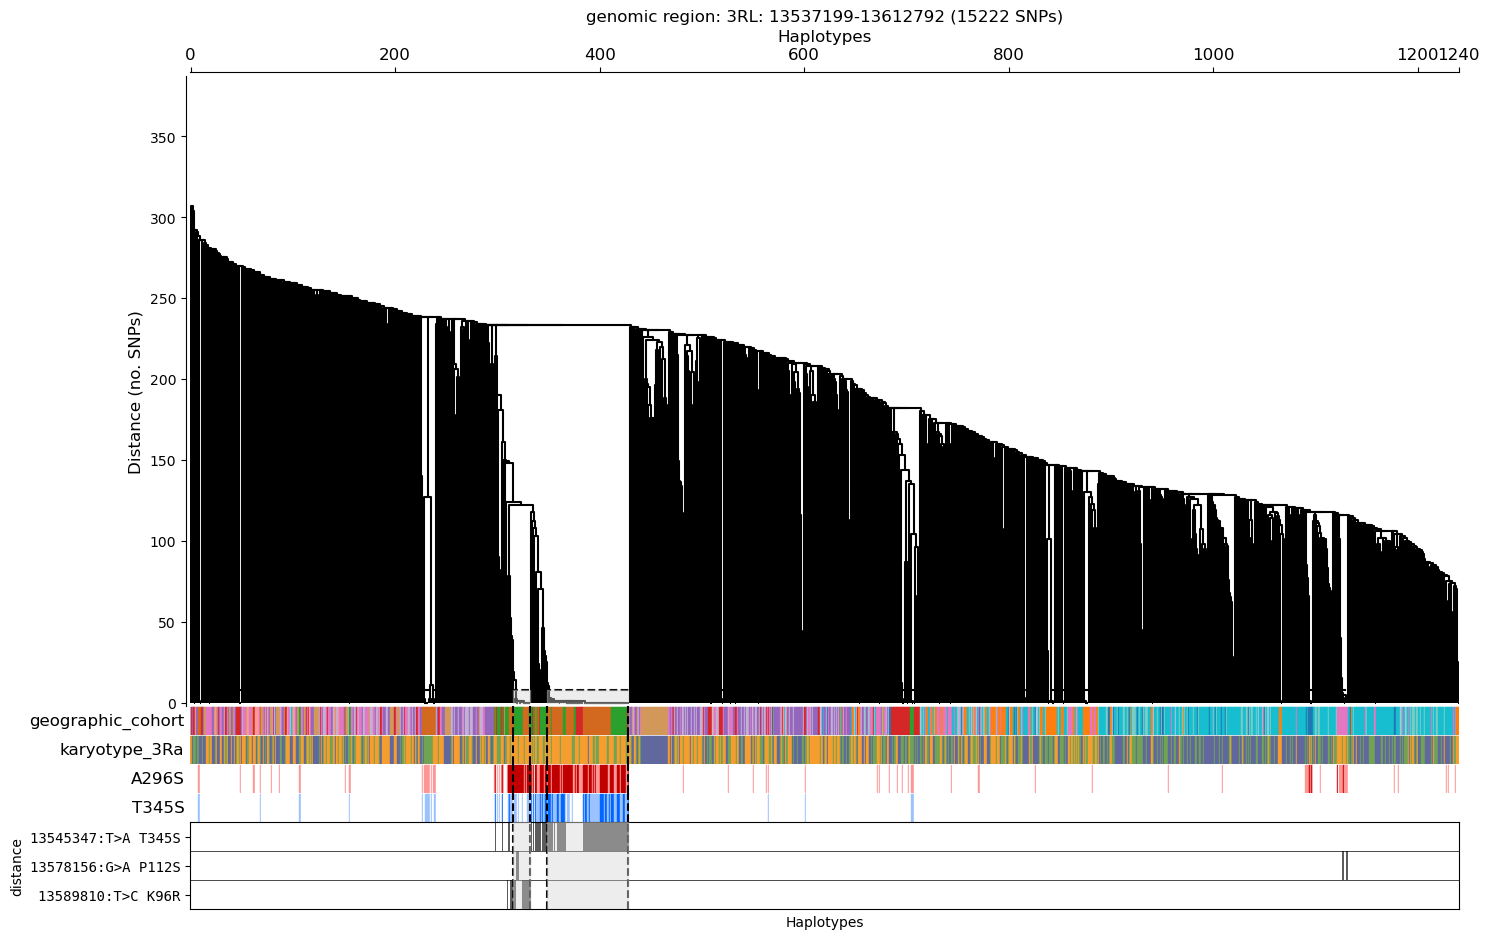

In [81]:
clusters, tbl_selected_redux, haps_missense, df_haplotypes, haps_redux = plot_dendrogram(
    transcripts, 
    cohorts=cohort_query,
    samples=sample_query,
    cut = cut, 
    n_clusters=n_clusters,
    maf_filter=0.055,
    # karyotype=None,
    # gt_aa_list=[],
)

### Output the clusters

In [ ]:
#generate a dictionary for all of the clusters in the clusters data
cluster_names = {i: f'C{i+1}' for i in range(len(clusters))}
clust_dict = {
    n: clusters[k] for k, n in cluster_names.items()
}
cluster_names.items()

In [ ]:
# make list of all indices (values) and their cluster names (keys) in clusters_good 
all_idx = []
all_clu = []
for n, s in clust_dict.items():
    for i in sorted(s):
        all_clu.append(n)
        all_idx.append(i)
        
len(all_idx), len(all_clu)

In [ ]:
# write out text file
clus_df = pd.DataFrame()
clus_df['cluster'] = all_clu
clus_df['haplotype'] = all_idx
clus_df.to_csv(f'data/clusters_for_{transcript}.csv', index=False)

### Generate cluster file

In [ ]:
cluster_samples = dict()
for l, c in zip(sorted(clust_dict), clusters):
    lc = list(c)
    cluster_samples[l] = set(df_haplotypes.query('index in @lc').geographic_cohort)

In [ ]:
#save the cluster membership file
save_cluster_membership(f'data/cluster_membership_for_{transcript}.npy', df_haplotypes, clusters, clust_dict)